# Solving the 2D Diffusion Equation on CPU & GPU

### Problem statement

Consider a square plate with sides $[−1,1]×[−1,1]$. At time $t=0$ we are heating the plate up such that the temperature is $u=5$ on one side and $u=0$ on the other sides. At what time does the plate reach $u=1$ at the center of the plate?

In [ ]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import timeit

### Introduction - The Heat Equation

The diffusion equation, also known as the heat equation, is:
$$\frac{\partial u}{\partial t} =
{\alpha} \left[ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right] $$

in 2 dimensions, where $u(x,t)$ is an unknown function to be solved for, $x$ is a coordinate in space, and $t$ is time. The coefficient $\alpha$ is the diffusion coefficient and determines how fast $u$ changes in time.

Typically, $u(x,t)$ could change rapidly change initially, but then becomes slower and slower. The solution is usually very smooth. The equation converges to a stationary solution as $t→∞$. This stationary limit of the diffusion equation is called the Laplace equation and arises in a very wide range of applications.

It is possible to solve for $u(x,t)$ using an explicit scheme, but there will be time step restrictions. Given that the solution is smooth, small time steps are not convenient and not required by accuracy as the diffusion process converges to a stationary state.

The following covers explicit and implicit time-stepping, where we replace $\frac{du}{dt}$ by a finite difference approximation. Results are benchmarked on the CPU and GPU.

### Explicit time-stepping - The Forward Euler Method

The forward Euler method uses a forward difference in time and a central difference in space to give:

$$
\frac{u_{i,j}^{(n+1)} - u_{i,j}^{(n)}}{\Delta t} = \alpha \left[ \frac{u_{i+1,j}^{(n)} - 2u_{i,j}^{(n)} + u_{i-1,j}^{(n)}}{(\Delta x)^2} + \frac{u_{i,j+1}^{(n)} - 2u_{i,j}^{(n)} + u_{i,j-1}^{(n)}}{(\Delta y)^2} \right],
$$

where space and time is discretised into a set of equally spaced mesh points: 

$$
x_i=i\Delta x,\quad i=0,\ldots,N_x
$$

$$
y_i=i\Delta x,\quad i=0,\ldots,N_y
$$

$$
t_n=n\Delta t,\quad n=0,\ldots,N_t {\thinspace .}
$$

Hence the PDE can be transformed into a simple set of equations:

$$
u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + \alpha \Delta t\left[ \frac{u_{i+1,j}^{(n)} - 2u_{i,j}^{(n)} + u_{i-1,j}^{(n)}}{(\Delta x)^2} + \frac{u_{i,j+1}^{(n)} - 2u_{i,j}^{(n)} + u_{i,j-1}^{(n)}}{(\Delta y)^2} \right].
$$

The algorithm becomes, for $n=0,1,…,N_t$:
1. use the above equation for all the internal spatial points $i=1,…,N_{x−1}$
2. set the boundary values $u^{n+1}_i=0$ for $i=0$ and $i=N_x$.

It can be shown that the maximum time step we can allow without the process becoming unstable is:

$$
\Delta t = \frac{1}{2D}\frac{(\Delta x\Delta y)^2}{(\Delta x)^2 + (\Delta y)^2}.
$$

In [2]:
def FE(u0, Lx, Ly, alpha, T):
    '''
    Function to solve the heat equation using explicit time
    stepping and the forward Euler method.
    Inputs
    u0: initial state of system (ndarray)
    Lx: length of sytem in x direction 
    Ly: length of sytem in y direction 
    alpha: diffusion coefficient 
    T: total time for sytem to evolve
    Outputs
    u: solution to heat equation at every timestep
    '''

    # Calculate relevant parameters required to specify dx, dy and dt 
    Nx, Ny = np.shape(u0)
    dx, dy = Lx/(Nx-1), Ly/(Ny-1)
    dt = (dx*dy)**2/(2*alpha*(dx**2 + dy**2))
    Nt = int(round(T/float(dt)))

    # Check timestep gives a stable solution
    if dt > (1/(2*alpha))*(dx*dy)**2 / (dx**2 + dy**2):
        print("Input parameters cause instability!")
    
    # Prepare next state and solution array
    u1 = np.copy(u0)
    u  = np.empty([Nt+1,Nx,Ny], dtype=np.float64)
    u[0,:,:] = u0

    # Solve discrete equation for every timestep
    for t in range(Nt):
        u1[1:-1,1:-1] = u0[1:-1,1:-1] + alpha*dt*(
            (u0[2:,1:-1] - 2*u0[1:-1,1:-1] + u0[:-2,1:-1])/dx**2
          + (u0[1:-1,2:] - 2*u0[1:-1,1:-1] + u0[1:-1,:-2])/dy**2)

        u[t+1,:,:] = u1
        u0 = u1  # update u0 before next step
    
    return u, dt

To solve the problem statement, we create a discrete array, $u$, with initial conditions: $u=5$ on one side and $u=0$ on all others. 

In [3]:
def u_0(N):  
    
    u = np.empty([N, N], dtype='float64')

    # Initial condition everywhere inside the grid
    u_initial = 0.0

    # Boundary conditions (fixed temperature)
    u_top = 5.0
    u_left = 0.0
    u_bottom = 0.0
    u_right = 0.0

    # Set the initial condition
    u.fill(u_initial)

    # Set the boundary conditions
    u[(N-1):, :(N-1)] = u_top
    u[:, :1] = u_left
    u[:1, 1:] = u_bottom
    u[:, (N-1):] = u_right
    
    return u

Note that a greater number of discretization points, $N$, would allow for greater accuracy. However, due to the mesh grid being two dimensions, we expect the time order complexity to increase as $O(N^2)$. Furthermore, the above method uses vectorization to compute the solution to the discrete equation rather than nested loops to cut computational time. This can be verified but in the interest of keeping the notebook short, it is ommited.

We compute the solution for a variety of grid sizes to illustrate:

In [4]:
t_expect = 0.424011387033

for N in range(11, 200, 20): # make sure N is odd so there is a defined centre coordinate
    
    start = timeit.default_timer()
    diffuse_FE, dt = FE(u_0(N), 2, 2, 1, 0.45)
    end = timeit.default_timer()

    centre_coord = int((N-1)/2)
    centre_temps = diffuse_FE[:,centre_coord,centre_coord]

    for t,temp in enumerate(centre_temps):
        if temp>=1:
            print('(N =', N,') u = 1 at t =', t*dt, 'relative error =', abs(t_expect - t*dt)/t_expect,'%  benchmark time = ', end - start, 's')
            break

(N = 11 ) u = 1 at t = 0.4200000000000001 relative error = 0.00946056439915307 %  benchmark time =  0.0009756770014064386 s
(N = 31 ) u = 1 at t = 0.42333333333333334 relative error = 0.0015991403070830692 %  benchmark time =  0.011893515002157073 s
(N = 51 ) u = 1 at t = 0.4236 relative error = 0.0009702263797175215 %  benchmark time =  0.03593720800199662 s
(N = 71 ) u = 1 at t = 0.42387755102040814 relative error = 0.0003156424961329024 %  benchmark time =  0.10315657099999953 s
(N = 91 ) u = 1 at t = 0.4239506172839506 relative error = 0.00014332103077379038 %  benchmark time =  0.24749908499870799 s
(N = 111 ) u = 1 at t = 0.4239669421487603 relative error = 0.00010482002511940737 %  benchmark time =  0.5473146650001581 s
(N = 131 ) u = 1 at t = 0.42396449704142014 relative error = 0.00011058663284488351 %  benchmark time =  1.007358145998296 s
(N = 151 ) u = 1 at t = 0.4240000000000001 relative error = 2.685548866880719e-05 %  benchmark time =  1.659537616000307 s
(N = 171 ) u = 

### Implicit time-stepping - The Backward Euler Method

In contrast with the forward scheme, we now apply a backward difference in time in but the same central difference in space:

$$
u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + \alpha \Delta t\left[ \frac{u_{i+1,j}^{(n+1)} - 2u_{i,j}^{(n+1)} + u_{i-1,j}^{(n+1)}}{(\Delta x)^2} + \frac{u_{i,j+1}^{(n+1)} - 2u_{i,j}^{(n+1)} + u_{i,j-1}^{(n+1)}}{(\Delta y)^2} \right].
$$

Here we can assume $u_{n−1}$ is computed, but all quantities at the next time level are unknown. It won't be possible to solve with respect to $u_n$ because this value couples to its neighbors in space which are unknown. The PDE is therefore decomposed into a linear set of equations. If we consider a simple case where $N_x = N_y = N$ (square grid) and $\Delta x = \Delta y$, we would have a system of $(N−1)×(N−1)$ algebraic equations for all the unknown $u_{i,j}^{n}$ at the interior spatial points $i, j$.

We can cleanly rewrite this by introducing the mesh fourier constant $F$:

$$
F = {\alpha}\frac{\Delta t}{\Delta x^2}{\thinspace}
$$

to give a five point stencil calculation:

$$
u_{i,j}^{(n)} = (1 + 4F) u_{i,j}^{(n+1)} - F u_{i+1,j}^{(n+1)} - F u_{i-1,j}^{(n+1)} - F u_{i,j+1}^{(n+1)} - F u_{i,j-1}^{(n+1)}
$$

Solving the system requires solving:

$$
u^{n}=Au^{n+1}
$$

where $A$ is a sparse matrix containing the 5 point stencil. 

It can be shown that the backward Euler method is unconditionally stable.

In [5]:
def BE(u0, Lxy, alpha, T):
    '''
    Function to solve the heat equation using implicit time
    stepping and the backward Euler method.
    Inputs
    u0: initial state of system (ndarray)
    Lxy: length of sytem in the x and y direction
    alpha: diffusion coefficient 
    T: total time for sytem to evolve
    Outputs
    u: solution to heat equation at every timestep
    '''
    
    # Calculate relevant parameters required to specify dx, dy and dt 
    N  = len(u0)
    dx = Lxy/(N-1)
    dt = dx**2/(4*alpha)
    Nt = int(round(T/float(dt)))
    F  = alpha*dt/dx**2
    
    # Prepare next state and solution array
    u1 = np.empty(N**2)          # solution array at t[n+1]
    u  = np.empty([Nt+1,N**2])   # solution array of all time steps

    # Representation of sparse matrix
    nelements = 5 * N**2 - 16 * N + 16
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    # Assign elements of sparse matrix
    count = 0
    for j in range(N):
        for i in range(N):
            # Insert boundry conditions
            if i == 0 or i == N-1 or j == 0 or j == N-1:
                row_ind[count] = col_ind[count] = j*N + i
                data[count] =  1
                count += 1
            # Insert elements from finite difference method (5pt stencil)    
            else:
                row_ind[count:count+5] = j*N + i
                col_ind[count] = j*N + i
                col_ind[count+1] = j*N + i + 1
                col_ind[count+2] = j*N + i - 1
                col_ind[count+3] = (j+1)*N + i
                col_ind[count+4] = (j-1)*N + i         
                data[count] = 1 + 4*F
                data[count+1:count+5] = -F
                count += 5
    
    # Create sparse matrix using coordinate format
    A = coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2))
    
    # Solve linear set of equations Ax=b (u1=A@u0)
    for t in range(Nt):
        b = u0.flatten()
        u1 = spsolve(A, b)
        u[t,:] = u1[:]

        # Update u_1 before next step
        u0 = u1
    
    return u, dt

Note that at each timestep we are solving a system of $(N-1)^2$ linear equations, which takes a lot of time.
The more grid points you have the closer you are getting to the continues limit of the diffusion equation. So it becomes more precise for greater number of grid points.

In [6]:
t_expect = 0.424011387033

for N in range(11, 60, 10): # make sure N is odd so there is a defined centre coordinate
    
    start = timeit.default_timer()
    diffuse_BE, dt = BE(u_0(N), 2, 1, 0.45)
    end = timeit.default_timer()

    centre_coord = int((N**2-1)/2)
    centre_temps = diffuse_BE[:,centre_coord]

    for t,temp in enumerate(centre_temps):
        if temp>=1:
            print('(N =', N,') u = 1 at t =', t*dt, 'relative error =', abs(t_expect - t*dt)/t_expect,'%  benchmark time = ', end - start, 's')
            break

(N = 11 ) u = 1 at t = 0.4300000000000001 relative error = 0.014123707877057587 %  benchmark time =  0.011768052998377243 s
(N = 21 ) u = 1 at t = 0.4250000000000001 relative error = 0.0023315717389522585 %  benchmark time =  0.1230360399968049 s


/home/taymaz/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


(N = 31 ) u = 1 at t = 0.42444444444444446 relative error = 0.001021334390273685 %  benchmark time =  0.6162030609993963 s
(N = 41 ) u = 1 at t = 0.42437500000000006 relative error = 0.0008575547216889942 %  benchmark time =  2.0050144759989053 s
(N = 51 ) u = 1 at t = 0.4244 relative error = 0.0009165154023793834 %  benchmark time =  5.253588324001612 s


Notice that for our CPU implementation, the explicit scheme computes the solution in less time for the same grid size $N$ and similar accuracy. For example, note: 

Explicit:
(N = 51 ) u = 1 at t = 0.4236 relative error = 0.0009702263797175215 %  benchmark time =  0.03705596500003594 s

Implicit:
(N = 51 ) u = 1 at t = 0.4244 relative error = 0.0009165154023793834 %  benchmark time =  5.203180170999985 s

which is a factor of 140 times longer. Both CPU schemes achieve the result to a maximum of 3 digits.

A nice animation can be made too:

<IPython.core.display.Javascript object>


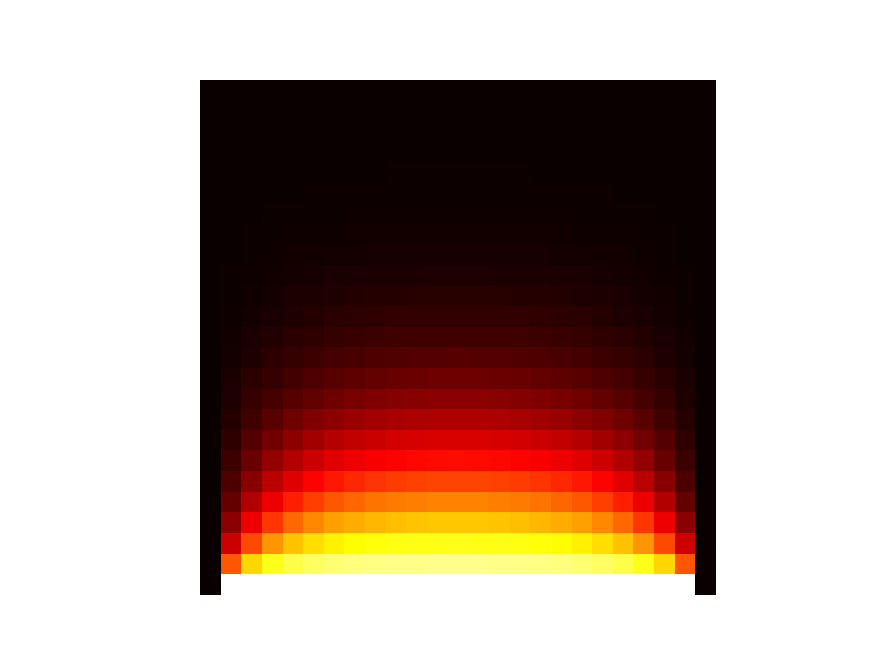

In [7]:
%matplotlib notebook

# instantiate function to animate
diffuse, dt = FE(u_0(25), 2, 2, 1, 100)

# set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
plt.axis('off')

# plot inital array
im = plt.imshow(u_0(55), cmap='hot')

# define the parameters of the animation
fps = 60
nSeconds = 5

# animate figure using the matplotlib animation.FuncAnimation class
def animate_func(i):
    im.set_array(diffuse[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds*fps, interval = 1000/fps)

### Using the GPU - The 5 point stencil

We can a 5 point stencil function (detailed in the '5 Point Stencil' notebook in this repo) to calculate the laplacian in 2d. Given that the forward difference can be written as:

$$U_{n+1}=U_n + \Delta t f(U_n,t_n)$$

where $f(U_n,t_n) = \Delta u$, we can calculate $U_{n+1}$.

The changes we make to function from the '5 Point Stencil' notebook are as follows:
*   set one of the global boundary condition to 5
*   scaled length from $[0,1]$ grid to $[-1,1]$ by changing (N-1) to (N-1)/2 in f.
*   changed signs in stencil calculation to calculate $\Delta u$ instead of $-\Delta u$.

In [8]:
# CUDA implementation of discrete laplacian operator with shared memory
import numba
from numba import cuda

# Thread block size of interior points
SX = 32 
SY = 32

# Total thread block size including 'halo' boundries
haloSX = SX + 2
haloSY = SY + 2

@cuda.jit
def evaluate_discrete_laplace(u_tilda, f, N):
    '''
    Evaluate the linear matrix problem: A_tilda @ u_tilda = f, 
    without the need to define the matrix A_tilda. Boundary values
    are set to zero.
    
    Keyword arguments:
    u_tilda  -- ndarray of shape [(N-2)^2,], corresponding to
                the solution at each interior point
    f        -- ndarray of shape [(N-2)^2,], corresponding to
                the interior nodes
    
    '''
    # Define shared memory
    local_u = cuda.shared.array((haloSX, haloSY), numba.float32)
    
    # Local thread position
    i = cuda.threadIdx.x
    j = cuda.threadIdx.y
    
    # Global thread position
    pi, pj = cuda.grid(2)
    
    if pi >= N-2:
        return
    if pj >= N-2:
        return
    
    # Compute the vector index
    pk = pj * (N - 2) + pi
    
    # Load interior points of each block
    local_u[i + 1, j + 1] = u_tilda[pk]
    
    # Load halo boundries of each block
    if i == 0 and pi != 0:                          # Left edges
        local_u[i, j + 1] = u_tilda[pk - 1]
    if j == 0 and pj != 0:                          # Top edges             
        local_u[i + 1, j] = u_tilda[pk - (N - 2)]
    if i == SX - 1 and pi != (N - 2) - 1:           # Right edges
        local_u[-1, j + 1] = u_tilda[pk + 1]
    if j == SY - 1 and pj != (N - 2) - 1:           # Bottom edges
        local_u[i + 1, -1] = u_tilda[pk + (N - 2)]

    # Load global boundry conditions (boundry values = 0)
    if pi == 0: 
        local_u[i, j + 1] = numba.float32(5)        # Global left edge
    if pj == 0: 
        local_u[i + 1,j] = numba.float32(0)         # Global top edge
    if pi == (N - 2) - 1:
        local_u[i + 2, j + 1] = numba.float32(0)    # Global right edge
    if pj == (N - 2) - 1:
        local_u[i + 1, j + 2] = numba.float32(0)    # Global bottom edge

    cuda.syncthreads()
    
    # Calculation of interior nodes in f
    up = local_u[i + 2, j + 1]
    down = local_u[i, j + 1]
    left = local_u[i + 1, j]
    right = local_u[i + 1, j + 2]
    center = local_u[i + 1, j + 1]
    
    cuda.syncthreads()

    f[pk] = ((N - 1)/2)**2 * (numba.float32(4) * (-center) + up + down + left + right) 
        

def eval_gpu(u_tilda):
    '''
    Evaluate the discrete Laplacian on the GPU.
    '''
    global N
    
    # Create empty array 
    f = np.empty((N-2)**2, dtype=np.float32)
    
    # Run GPU kernal
    nblocks = ((N-2) + 31) // 32
    evaluate_discrete_laplace[(nblocks, nblocks), (32, 32)](u_tilda.astype('float32'), f, N)
    
    return f.astype('float64')

We can make and benchmark a simple function to find the time taken to reach $u = 1$. 

In [9]:
def time_to_reach_1(N, dt):
    
    # Initialize solution array
    u0 = np.zeros((N-2)**2)
    
    # Define centre point
    center_coord = ((N-2) + 1)*(int((N-2)/2))  
    
    # Find time taken until centre becomes greater than 1
    t = 0
    while u0[center_coord] < 1:
        u1 = eval_gpu(u0)
        t += dt
        u0 += u1*dt 

    return t

In [10]:
alpha = 1

for N in range(11,100,20):
    
    dx = 2/(N-1)
    dt = dx**2/(4*alpha)
    
    start = timeit.default_timer()
    t = time_to_reach_1(N,dt)
    end = timeit.default_timer()
    
    print('(N =', N,') u = 1 at t =', t, 'relative error =', abs(t_expect - t)/t_expect,'%  benchmark time = ', end - start, 's')

(N = 11 ) u = 1 at t = 0.4200000000000003 relative error = 0.009460564399152546 %  benchmark time =  0.4163459849987703 s
(N = 31 ) u = 1 at t = 0.4233333333333349 relative error = 0.0015991403070794033 %  benchmark time =  0.2630778189995908 s
(N = 51 ) u = 1 at t = 0.423600000000008 relative error = 0.0009702263796985383 %  benchmark time =  0.702835056999902 s
(N = 71 ) u = 1 at t = 0.4238775510204128 relative error = 0.0003156424961219052 %  benchmark time =  1.4061105220025638 s
(N = 91 ) u = 1 at t = 0.42395061728392214 relative error = 0.00014332103084095183 %  benchmark time =  2.3405371909975656 s


We see that, for sufficiently small $dt$ such that forward Euler remains stable, the GPU function has quicker compute time (only noticable for large grid sizes) with less error for the same sized grids.